The dataset we are going to use today is **Boston Dataset**. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import random
from sklearn import feature_selection
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing


In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/Boston.csv"
BostonData = pd.read_csv(url)
del BostonData['Unnamed: 0']
print BostonData.shape
BostonData.head()

(506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

crim: per capita crime rate by town 
    
zn: proportion of residential land zoned for lots over 25,000 sq.ft. 
    
indus: proportion of non-retail business acres per town 
    
chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
    
nox: nitrogen oxides concentration (parts per 10 million) 
    
rm: average number of rooms per dwelling 
    
age: proportion of owner-occupied units built prior to 1940 
    
dis: weighted mean of distances to five Boston employment centres 
    
rad: index of accessibility to radial highways 
    
tax: full-value property-tax rate per 10,000 dollars
    
ptratio: pupil-teacher ratio by town 
    
black: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
    
lstat: lower status of the population (percent) 
    
medv: median value of owner-occupied homes in 1000 dollars

Source

Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.

Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.
[Package MASS version 7.2-29 Index]


#### Our goal is to predict the median value of properties (medv) based on other variables in this dataset.

#### First let's draw a scatter-plot of medv and lstat. Intuitively, does it like a pure linear association or it seems like there is some sort of non-linearity?

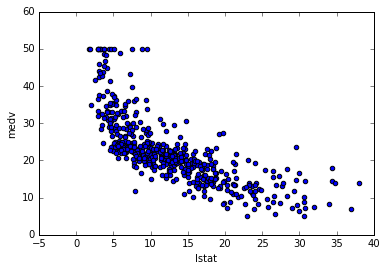

In [3]:
BostonData[['medv','lstat']].plot(kind='scatter',x='lstat',y='medv')

Answer: There appears to be a form of non-linearity

#### Now, let's first define few non-linear terms. Start from a pure linear function and go up to polynomial degree 5. 

In [4]:
BostonData['lstat_2'] = BostonData['lstat']**2
BostonData['lstat_3'] = BostonData['lstat']**3
BostonData['lstat_4'] = BostonData['lstat']**4
BostonData['lstat_5'] = BostonData['lstat']**5
X1 = BostonData[['lstat']]
X2 = BostonData[['lstat','lstat_2']]
X3 = BostonData[['lstat','lstat_2','lstat_3']]
X4 = BostonData[['lstat','lstat_2','lstat_3','lstat_4']]
X5 = BostonData[['lstat','lstat_2','lstat_3','lstat_4','lstat_5']]
y = BostonData['medv']
#If a model goes to polynomial value k, then all lower powers need to be included in the model even if they are not significant
#Never go above polynomial power of four due to issues with confidence intervals at edges

#### Now divide your dataset into 25% test set and 75% training set and use Validation and MSE of test set to decide which degree of polynomial fits the best. Run this procedure a few times!

    MSE_test  MSE_train  index
0  45.597599  36.180914      1
1  42.896222  26.530893      2
2  28.575461  29.087903      3
3  24.728424  28.631082      4
4  34.750790  24.626805      5


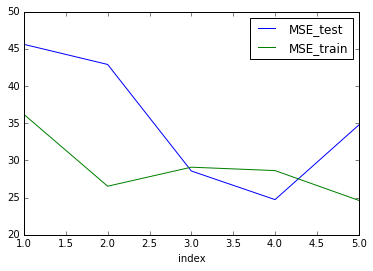

In [5]:
MSE_test = np.zeros(5)
MSE_train = np.zeros(5)
lm = linear_model.LinearRegression()
j=0
for i in [X1,X2,X3,X4,X5]:
    X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.25)
    lm.fit(X_train,y_train)
    y_hat_train = lm.predict(X_train)
    y_hat_test = lm.predict(X_test)
    MSE_train[j] = metrics.mean_squared_error(y_hat_train,y_train)
    MSE_test[j] = metrics.mean_squared_error(y_hat_test,y_test)
    j+=1

MSE_df = pd.DataFrame({'MSE_test':MSE_test,'index':np.arange(1,6),'MSE_train':MSE_train})
print MSE_df

MSE_df.plot(x='index',y=['MSE_test','MSE_train'])

Answer: Second order appears to minimize the test error, but there is an issue here as the results are not repeatable

#### Now, on the same data set, use 10 fold cross-validation to decide on the degree of polynomial. Justify what you find.

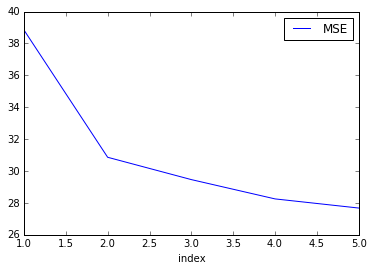

In [6]:
kf = cross_validation.KFold(len(BostonData), n_folds = 10, shuffle = True) #List of tuples in (train,test) order
MSE_CV = []

for i in [X1,X2,X3,X4,X5]:
    scores = []
    for train_index, test_index in kf:
        lm.fit(i.iloc[train_index],y.iloc[train_index])
        yhat_test = lm.predict(i.iloc[test_index])
        mse = metrics.mean_squared_error(y.iloc[test_index],yhat_test)
        scores.append(mse)
    MSE_CV.append(np.mean(scores))

MSE_CV_df = pd.DataFrame({'MSE':MSE_CV,'index':np.arange(1,6)})
MSE_CV_df.plot(y='MSE',x='index')    

Answer: THE MSE appears to level off around the power of two but could be taken to power of four if interpreted differently

# Now let's consider more variables.

#### Let's first focus on correlation Matrix.

In [7]:
# Let's first get rid of additional variables we added to our dataframe
del BostonData['lstat_2']
del BostonData['lstat_3']
del BostonData['lstat_4']
del BostonData['lstat_5']

In [8]:
print abs(BostonData.corr()['medv']).sort_values(ascending=False)
BostonData[['rm','ptratio','lstat']].corr()

medv       1.000000
lstat      0.737663
rm         0.695360
ptratio    0.507787
indus      0.483725
tax        0.468536
nox        0.427321
crim       0.388305
rad        0.381626
age        0.376955
zn         0.360445
black      0.333461
dis        0.249929
chas       0.175260
Name: medv, dtype: float64


,rm,ptratio,lstat
rm,1.000000,-0.355501,-0.613808
ptratio,-0.355501,1.000000,0.374044
lstat,-0.613808,0.374044,1.000000


#### List 3 variables that have the highest chance to appear in your final model - the model that can predict medv. Can these variables appear simultaneously in your final model if your goal is interpretation?

Answer: lstat, rm, and ptratio appear to be the most correlated with medv; all appear to be correlated, so they should not be used together for interpretation (ok to use for prediction)

#### Now let's standardize our data and put it in a new DataFrame called BostonDataNew

In [9]:
normalized_data = preprocessing.scale(BostonData)
BostonDataNew = pd.DataFrame(normalized_data,columns = BostonData.columns.values)
BostonDataNew.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.159686
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101524
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.324247
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.487503


#### Now let's use 10-fold cross validation and Lasso regression on our standardized data to decide which variables to eliminate.

In [10]:
listOfAllVariables = BostonData.columns.values
X = BostonDataNew[listOfAllVariables]
del X['medv']
y = BostonDataNew['medv']

    Log_alphas  MSE_Lasso_CV
0          -10      0.278428
1           -9      0.278428
2           -8      0.278428
3           -7      0.278428
4           -6      0.278428
5           -5      0.278427
6           -4      0.278423
7           -3      0.278347
8           -2      0.284033
9           -1      0.342918
10           0      1.005611
11           1      1.005611
12           2      1.005611
13           3      1.005611
14           4      1.005611
15           5      1.005611
16           6      1.005611
17           7      1.005611
18           8      1.005611
19           9      1.005611
20          10      1.005611


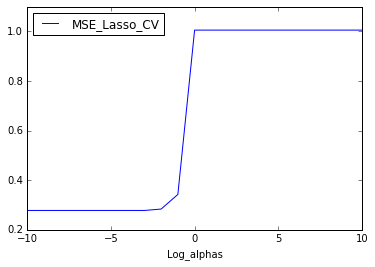

In [17]:
kf = cross_validation.KFold(len(BostonDataNew), n_folds=10, shuffle=True)
MSE_Lasso_CV = []
alphas = np.logspace(-10,10,21)
index = np.arange(-10,11)

for a in alphas:
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.Lasso(alpha=a)
        lm.fit(X.iloc[train_index],y.iloc[train_index])
        mse = metrics.mean_squared_error(y.iloc[test_index],lm.predict(X.iloc[test_index]))
        scores.append(mse)
    MSE_Lasso_CV.append(np.mean(scores))

MSE_Lasso_df = pd.DataFrame({'MSE_Lasso_CV':MSE_Lasso_CV,'Log_alphas':index})
print MSE_Lasso_df
MSE_Lasso_df.plot(x='Log_alphas',y='MSE_Lasso_CV')

In [24]:
#Possible to work with 10^-2 or 10^-1; choose -1 to keep model as simple as possible
lm = linear_model.Lasso(alpha=10**(-1))
lm.fit(X,y)
coef_df = pd.DataFrame({'coefficient':lm.coef_},index=X.columns.values)
print coef_df

         coefficient
crim       -0.000000
zn          0.000000
indus      -0.000000
chas        0.007395
nox        -0.000000
rm          0.300186
age        -0.000000
dis        -0.000000
rad        -0.000000
tax        -0.000000
ptratio    -0.150762
black       0.026240
lstat      -0.387010


Answer: The variables to keep from the Lasso regression are rm, ptratio, and lstat; black and chas also have a small effect

#### Now let's use 10-fold cross validation to choose our best model among the following candidates. Let's first add lstat**2 to our model. 

In [26]:
BostonData['lstat_2'] = BostonData['lstat']**2
X1 = BostonData[['lstat']]
X2 = BostonData[['lstat','lstat_2']]
X3 = BostonData[['lstat','chas']]
X4 = BostonData[['lstat','lstat_2','chas']] #'chas' is highly correlated with lstat - can't consider them simultaneously
X5 = BostonData[['ptratio','chas']]
X6 = BostonData[['ptratio','chas','black']]
X7 = BostonData[['ptratio','black']]
X8 = BostonData[['rm']]
X9 = BostonData[['rm','chas']]
X10 = BostonData[['rm','chas','black']]
X11 = BostonData[['rm','black']]
X12 = BostonData[['lstat','ptratio','rm']]  #model without that much interpretability
X13 = BostonData[['lstat','lstat_2','ptratio','rm']]  #model without that much interpretability
X14 = BostonData[['lstat','ptratio','rm','chas','black']]  #model without that much interpretability
X15 = BostonData[['lstat','lstat_2','ptratio','rm','chas','black']]  #model without that much interpretability
y = BostonData['medv']

In [34]:
# Use 10 fold cross-validation to decide on the model of your interest
kf = cross_validation.KFold(len(BostonData), n_folds=10, shuffle=True)
MSE_CV = []

for i in [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15]:
    scores=[]
    lm = linear_model.LinearRegression()
    for train_index, test_index in kf:
        lm.fit(i.iloc[train_index],y.iloc[train_index])
        mse = metrics.mean_squared_error(y.iloc[test_index],lm.predict(i.iloc[test_index]))
        scores.append(mse)
    MSE_CV.append(np.mean(scores))

# MSE_CV_df = pd.DataFrame({'MSE': MSE_CV},index=np.arange(1,(len(MSE_CV)+1))
# MSE_CV_df


          MSE
1   38.698162
2   30.521791
3   37.419796
4   29.202519
5   62.785604
6   57.642893
7   57.869539
8   44.106578
9   43.376575
10  38.482160
11  39.112833
12  27.833783
13  23.666426
14  26.813812
15  22.584422


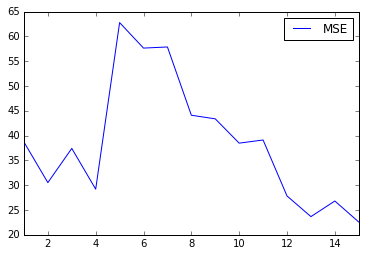

In [40]:
MSE_CV_df = pd.DataFrame({'MSE':MSE_CV},index=np.arange(1,(len(MSE_CV)+1)))
print MSE_CV_df
MSE_CV_df.plot(y='MSE')

#### If your goal is interpretation - what model(s) are you going to use? Use  smf.ols  in "statsmodels.formula.api as smf" to test significancy of your coefficients. 

Answer: If the goal is interpretability, use either model 2 or 4. If all variables are significant, use model 4

In [45]:
for i in [X2,X4]:
    lm1 = smf.ols(formula='y ~ i', data=BostonData).fit()
    print(lm1.summary())
    print "\n \n ------------------------------------------ \n \n"
#All variables are significant, so use model 4

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Tue, 23 Feb 2016   Prob (F-statistic):          1.56e-112
Time:                        08:50:20   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     42.8620      0.872     49.149      0.0

#### If your goal is prediction - what model(s) are you going to use? Use  smf.ols  in "statsmodels.formula.api as smf" to test significancy of your coefficients. 

Answer: 

In [46]:
for i in [X12,X12,X14,X15]:
    lm1 = smf.ols(formula='y ~ i', data=BostonData).fit()
    print(lm1.summary())
    print "\n \n ------------------------------------------ \n \n"
    #All of our models are highly significant, so we use model 15. It generates the least CV-MSE. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     353.3
Date:                Tue, 23 Feb 2016   Prob (F-statistic):          2.69e-123
Time:                        08:52:02   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3114.
Df Residuals:                     502   BIC:                             3131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     18.5671      3.913      4.745      0.0